###### Links: [Covid-19 dataset (JohnsHopkinsUniversity)](https://github.com/CSSEGISandData/COVID-19)

### 0 - Setup

###### Import pckgs 

In [1]:
#!conda install -c conda-forge fbprophet -y


done

## Package Plan ##

  environment location: /Users/vsingh/anaconda3/envs/PythonData

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cctools-895                |                1         1.9 MB  conda-forge
    clang-4.0.1                |                1        73.9 MB  conda-forge
    clang_osx-64-4.0.1         |      h1ce6c1d_17         145 KB  conda-forge
    clangxx-4.0.1              |                1         263 KB  conda-forge
    convertdate-2.2.1          |     pyh9f0ad1d_0          33 KB  conda-forge
    fbprophet-0.5              |   py36h6de7cb9_0         639 KB  conda-forge
    holidays-0.10.2            |     pyh9f0ad1d_0          59 KB  conda-forge
    korean_lunar_calendar-0.2.1|     pyh9f0ad1d_0          10 KB  conda-forge
    llvm-4.0.1                 |                1       136.6 MB  conda-forge
    lunardate-0.2.0 

In [9]:
#!pip install holidays

In [41]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
## For parametric fitting
from scipy import optimize
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *

###### Import data

In [42]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,208,208,220,235,235,235,235,246,251,251
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,56,65,70,85,106,122,128,130,167,184
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,34
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,661,729,801,907,1118,1322,1524,1729,1936,2140
265,NaN,Lesotho,-29.609988,28.233608,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1


###### I'll select 1 country (ex. Italy) and look at 2 time series: 
- total cases per day
- daily changes, i.e. new cases distribution

In [43]:
## groupby country
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["Italy"].values, columns=["total"])

## create daily changes column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')

In [24]:
dtf.head()

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


In [44]:
dtf.tail()

,total,new
2020-05-16,224760,875.0
2020-05-17,225435,675.0
2020-05-18,225886,451.0
2020-05-19,226699,813.0
2020-05-20,227364,665.0


### 1 - TimeSeries Analysis (cumulated cases)

###### I have to find the best curve to fit the data:
- y = f(x)
- x = t

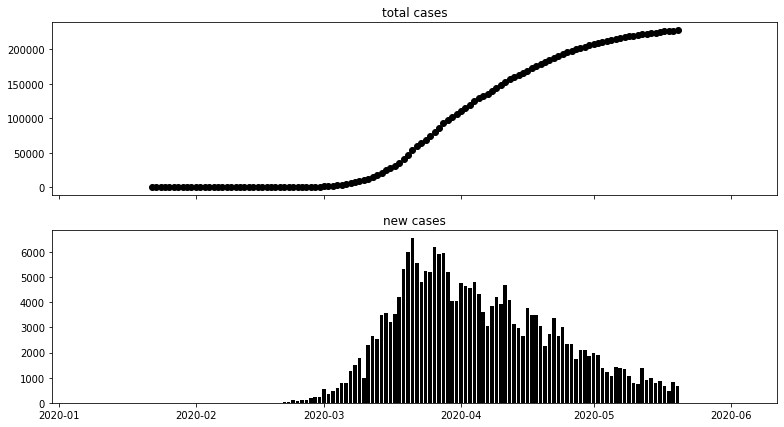

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,7))
ax[0].scatter(dtf.index, dtf["total"].values, color="black")
ax[0].set(title="total cases")
ax[1].bar(dtf.index, dtf["new"].values, color="black")
ax[1].set(title="new cases")
plt.show()

###### Total cases

In [46]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 1500*x

y_linear = f(x=np.arange(len(dtf)))

In [47]:
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.18**x

y_exponential = f(x=np.arange(len(dtf)))

In [48]:
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

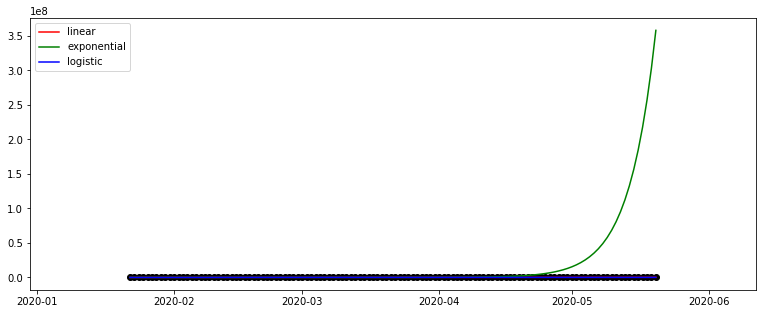

In [49]:
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

In [50]:
#-> Data starts low and grows exponentially ... looks similar to a exponential function. But I know for fact that
#   this phenomenon has an upper limit, because the virus can't infect more than the total population of the country.
#   Therefore the logistic function is more appropriate to model this data.

###### New cases

In [51]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 6000 * np.exp(-0.5 * ((x-60)/6)**2)

y_gaussian = f(x=np.arange(len(dtf)))

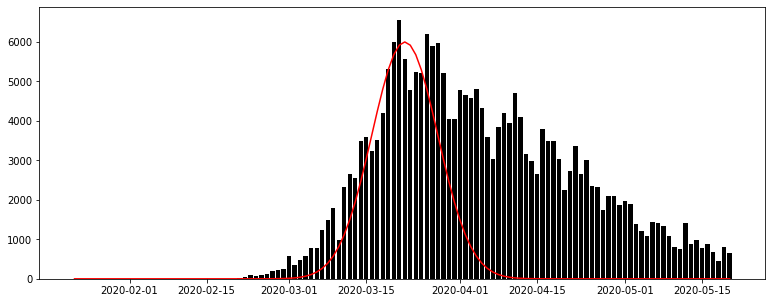

In [52]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

### 2 - Model Desing & Testing

###### Total cases

In [53]:
'''
Function to fit. In this case logistic function:
    f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

In [54]:
## Fit
model = fit_curve(X=np.arange(len(dtf["total"])), y=dtf["total"].values, f=f, p0=[np.max(dtf["total"]), 1, 1])
model

array([2.21633620e+05, 9.88739583e-02, 7.14254855e+01])

--- generating index date --> start: 2020-05-21 00:00:00 | end: 2020-06-18 00:00:00 | len: 29 ---


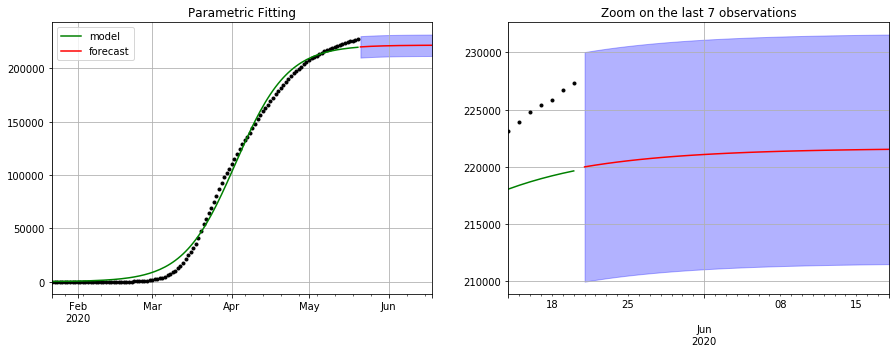

In [55]:
## Forecast
preds = forecast_curve(dtf["total"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

###### New cases

In [56]:
'''
Function to fit. In this case gaussian function:
    f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y

In [57]:
model = fit_curve(X=np.arange(len(dtf["new"])), y=dtf["new"].values, f=f, p0=[1, np.mean(dtf["new"]), np.std(dtf["new"])])
model

array([5048.99918664,   70.3844099 ,   17.97569604])

--- generating index date --> start: 2020-05-21 00:00:00 | end: 2020-06-18 00:00:00 | len: 29 ---


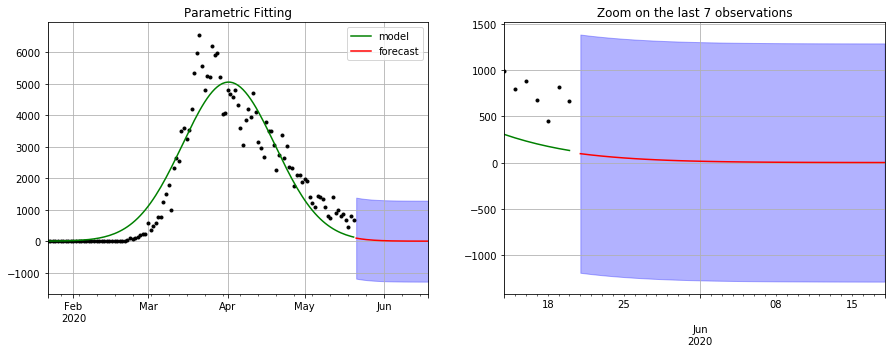

In [58]:
## Forecast
preds = forecast_curve(dtf["new"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))